<a href="https://colab.research.google.com/github/igedemadepradnyaairlangga/Dataanalitycs/blob/master/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Data: Membuat Model Machine Learning dengan Data Time Series
- Nama: I Gede Made Pradnya Airlangga
- Email: pradnya.airlangga@gmail.com
- Id Dicoding: I Gede Made Pradnya Airlangga

Sumber Dataset : https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting

## Menentukan Pertanyaan Bisnis

- Bagaimana Analisis Pola Penjualan Bulanan ?
- Bagaimana Analisis Penjualan Berdasarkan Segmen Pelanggan ?
- Bagaimana Analisis Penjualan Berdasarkan Kategori Prooduk?
- Bagaimana Analisis Tren Penjualan Tahunannya?
- Bagaimana Analisis Pola Penjualan Hariannya ?
- Bagaimana Analisis Preferensi Pelanggan berdasarkan Pengeluarannya ?
- Bagaimana Analisis Tren Pasarnya ?

## Menghubungkan ke dataset yang ada di google drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [5]:
!ls

 0t08v9bAaA0mXGCQ.png		 penjualan.csv
 alldata_1_for_kaggle.csv	 rockpaperscissors
 amazon_prime_titles.csv	 rock_paper_scissors_final_model.h5
 best_model.h5			 rock_paper_scissors_model.h5
 combined_dataset.csv		'Salinan amazon_prime_titles.csv'
 day.csv			 selic.csv
'e-shop clothing 2008.csv'	 testkt2.csv
'e-shop clothing 2008.csv.zip'	 testkt.csv
 hour.csv			 train.csv
 kaggle.json			 trainkt2.csv
 klasifikasiteks		 trainkt.csv
 Mall_Customers.csv		 udemy_output_All_Finance__Accounting_p1_p626.csv
 model_sentiment.h5		 vectorizer.pkl
 OdfDTwgPVdW9XbE7.png		 world_news_in_month.csv


## Menyaipkan semua library yang dibutuhkan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from google.colab import drive

## Cleaning Data

In [6]:
# Mengimpor dataset dari file CSV
file_path = '/content/drive/MyDrive/Kaggle/penjualan.csv'
df = pd.read_csv('penjualan.csv')

In [7]:
# 1. Penghapusan Kolom yang Tidak Diperlukan
cols_to_drop = ["Row ID", "Order ID", "Ship Date", "Customer ID", "Customer Name", "Postal Code", "Product ID", "Product Name"]
df = df.drop(cols_to_drop, axis=1)

In [8]:
# Cek nilai yang hilang
missing_values = df.isnull().sum()
print("Jumlah nilai yang hilang sebelum penanganan:")
print(missing_values)

Jumlah nilai yang hilang sebelum penanganan:
Order Date      0
Ship Mode       0
Segment         0
Country         0
City            0
State           0
Region          0
Category        0
Sub-Category    0
Sales           0
dtype: int64


In [9]:
# Periksa dan hapus duplikat
df.drop_duplicates(inplace=True)

In [10]:
# Lakukan analisis outlier pada kolom "Sales"
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

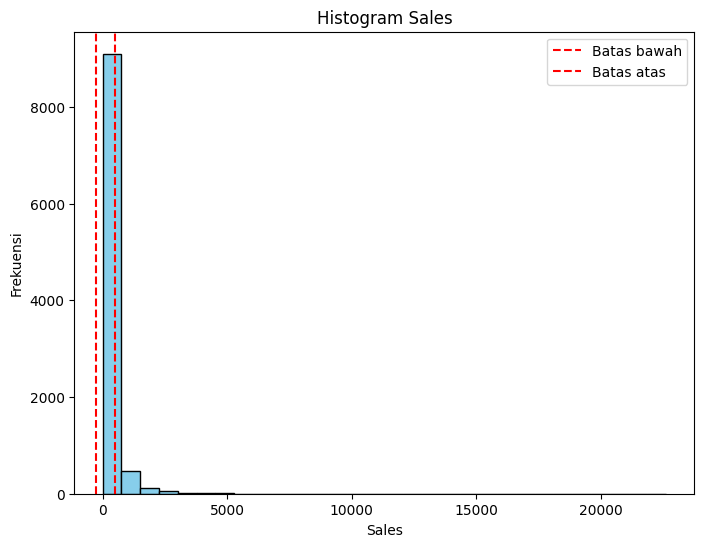

In [11]:
# Plot histogram untuk visualisasi distribusi data
plt.figure(figsize=(8, 6))
plt.hist(df['Sales'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=lower_bound, color='red', linestyle='--', label='Batas bawah')
plt.axvline(x=upper_bound, color='red', linestyle='--', label='Batas atas')
plt.title('Histogram Sales')
plt.xlabel('Sales')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

In [12]:
# Hapus outlier
df_cleaned = df[(df['Sales'] > lower_bound) & (df['Sales'] < upper_bound)]

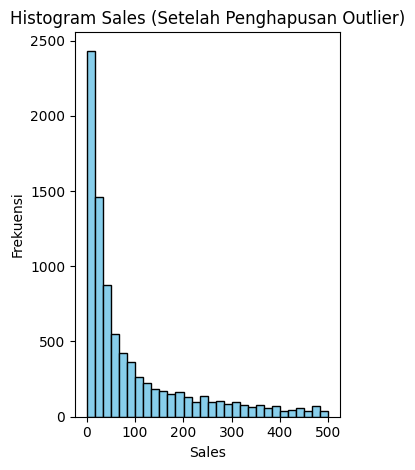

In [13]:
plt.subplot(1, 2, 2)
plt.hist(df_cleaned['Sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Sales (Setelah Penghapusan Outlier)')
plt.xlabel('Sales')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [14]:
# Cetak informasi outlier
outliers = df[(df['Sales'] < lower_bound) | (df['Sales'] > upper_bound)]
print("Jumlah outlier:", len(outliers))
print("Outlier:")
print(outliers)

Jumlah outlier: 1145
Outlier:
      Order Date       Ship Mode    Segment        Country             City  \
1     08/11/2017    Second Class   Consumer  United States        Henderson   
3     11/10/2016  Standard Class   Consumer  United States  Fort Lauderdale   
7     09/06/2015  Standard Class   Consumer  United States      Los Angeles   
10    09/06/2015  Standard Class   Consumer  United States      Los Angeles   
11    09/06/2015  Standard Class   Consumer  United States      Los Angeles   
...          ...             ...        ...            ...              ...   
9759  31/10/2017  Standard Class  Corporate  United States    San Francisco   
9774  26/07/2015  Standard Class   Consumer  United States      San Antonio   
9781  14/09/2017  Standard Class   Consumer  United States       Long Beach   
9787  27/03/2018  Standard Class   Consumer  United States          Houston   
9788  27/03/2018  Standard Class   Consumer  United States          Houston   

           State   Re

##Membuat Model Machine Learning dengan Data Time Series

In [15]:
# Mengimpor dataset dari file CSV
file_path = '/content/drive/MyDrive/Kaggle/penjualan.csv'
df = pd.read_csv('penjualan.csv')

In [16]:
# Pilih kolom yang akan digunakan sebagai fitur dan target
X = df['Order Date']
y = df['Sales']

In [17]:
# Ubah tipe data kolom 'Order Date' menjadi datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

<ipython-input-17-d01687bde571>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Order Date'] = pd.to_datetime(df['Order Date'])


In [18]:
# Ubah 'Order Date' menjadi nilai numerik yang sesuai, misalnya jumlah hari sejak awal periode
df['order_date_numeric'] = (df['Order Date'] - df['Order Date'].min()).dt.days

In [19]:
# Pilih kolom 'order_date_numeric' sebagai fitur X
X = df['order_date_numeric']
y = df['Sales']

In [20]:
# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values.reshape(-1, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [21]:
# Bagi dataset menjadi training set dan validation set
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [22]:
# Tampilkan hasil pembagian data
print("Jumlah data training:", len(X_train))
print("Jumlah data validasi:", len(X_val))

Jumlah data training: 7840
Jumlah data validasi: 1960


In [23]:
# Bentuk dataset untuk LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
X_train, y_train = create_dataset(X_train, y_train, TIME_STEPS)
X_val, y_val = create_dataset(X_val, y_val, TIME_STEPS)

In [24]:
# Bangun model LSTM
model = Sequential([
    LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])

In [25]:
# Atur optimizer dengan learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

In [26]:
# Latih model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/10
245/245 [==============================] - 4s 9ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 2/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0095 - val_mae: 0.0095
Epoch 3/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0102 - mae: 0.0102 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 4/10
245/245 [==============================] - 2s 10ms/step - loss: 0.0099 - mae: 0.0099 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 5/10
245/245 [==============================] - 2s 10ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0096 - val_mae: 0.0096
Epoch 6/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0096 - mae: 0.0096 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0095 - mae: 0.0095 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 8/10
245/245 [==============================] - 2s 7ms/step - loss: 

In [27]:
# Evaluasi model
val_loss, val_mae = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation MAE:", val_mae)

61/61 [==============================] - 0s 3ms/step - loss: 0.0094 - mae: 0.0094
Validation Loss: 0.009406483732163906
Validation MAE: 0.009406483732163906


In [28]:
# Hitung ambang batas skala 10%
threshold_mae = (df['Sales'].max() - df['Sales'].min()) * 10/100
print("Ambang Batas Skala 10%:", threshold_mae)

Ambang Batas Skala 10%: 2263.8035999999997


In [30]:
# Ambang batas skala 10%
threshold_mae = 2263.8035999999997

# MAE yang dihasilkan oleh model (dalam contoh ini, menggunakan nilai yang Anda berikan)
val_mae = 0.0094

# Memeriksa apakah MAE < 10% skala data
if val_mae < threshold_mae:
    print("Model memenuhi kriteria 'MAE < 10% skala data'.")
else:
    print("Model tidak memenuhi kriteria 'MAE < 10% skala data'.")

Model memenuhi kriteria 'MAE < 10% skala data'.


##Analisis Pola Penjualan

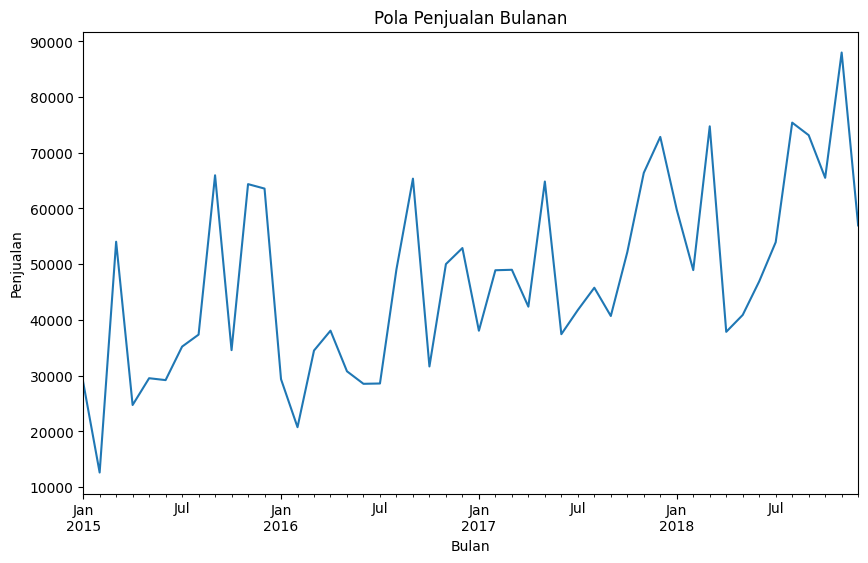

In [31]:
# Misalnya, kita akan melihat pola penjualan sepanjang waktu
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['YearMonth'] = df['Order Date'].dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['Sales'].sum()
monthly_sales.plot(kind='line', figsize=(10, 6), title='Pola Penjualan Bulanan')
plt.xlabel('Bulan')
plt.ylabel('Penjualan')
plt.show()

## Analisis Preferensi Pelanggan

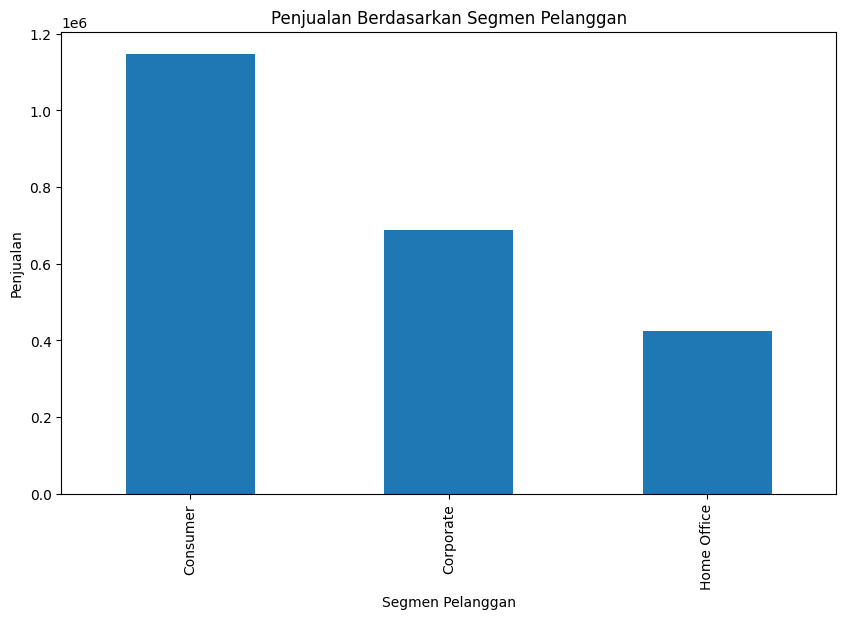

In [32]:
segment_sales = df.groupby('Segment')['Sales'].sum().sort_values(ascending=False)
segment_sales.plot(kind='bar', figsize=(10, 6), title='Penjualan Berdasarkan Segmen Pelanggan')
plt.xlabel('Segmen Pelanggan')
plt.ylabel('Penjualan')
plt.show()

##Analisis Kinerja Produk

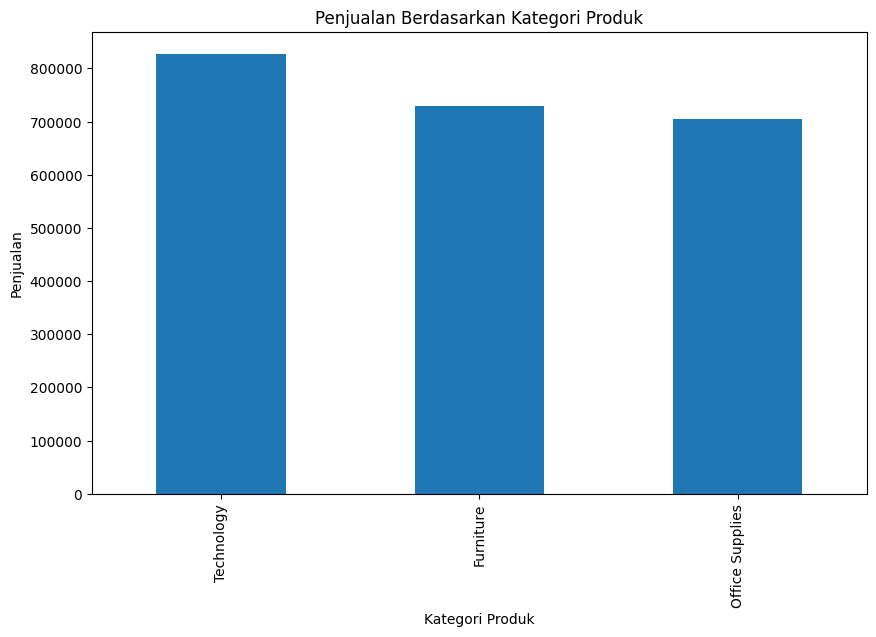

In [33]:
category_sales = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
category_sales.plot(kind='bar', figsize=(10, 6), title='Penjualan Berdasarkan Kategori Produk')
plt.xlabel('Kategori Produk')
plt.ylabel('Penjualan')
plt.show()

##Analisis Tren Pasar

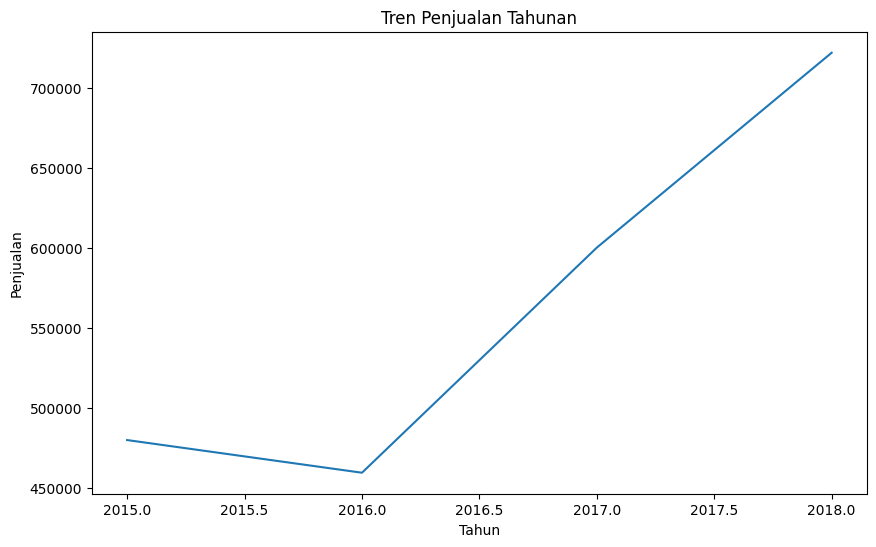

In [34]:
df['Year'] = df['Order Date'].dt.year
yearly_sales = df.groupby('Year')['Sales'].sum()
yearly_sales.plot(kind='line', figsize=(10, 6), title='Tren Penjualan Tahunan')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.show()

##Analisis Pola Penjualan

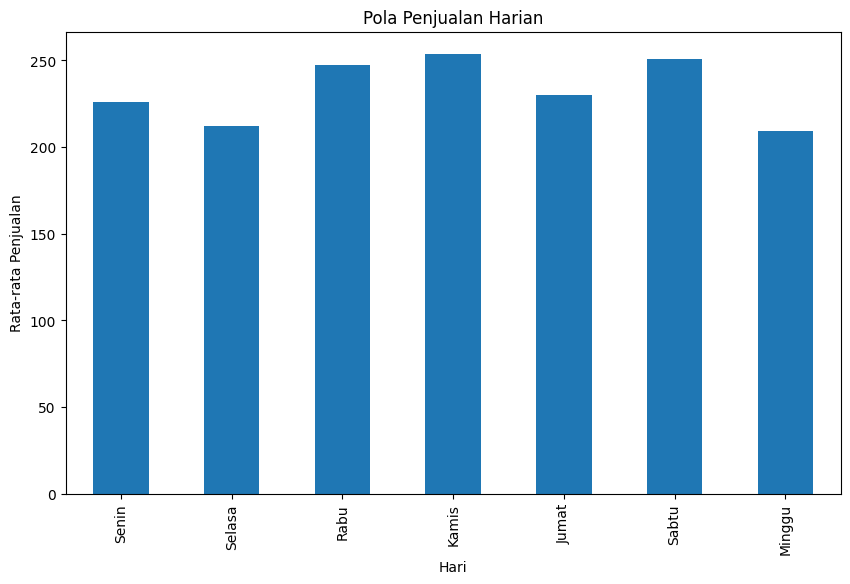

In [35]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_sales = df.groupby(df['Order Date'].dt.dayofweek)['Sales'].mean()
days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
daily_sales.index = days
daily_sales.plot(kind='bar', figsize=(10, 6), title='Pola Penjualan Harian')
plt.xlabel('Hari')
plt.ylabel('Rata-rata Penjualan')
plt.show()

##Analisis Preferensi Pelanggan

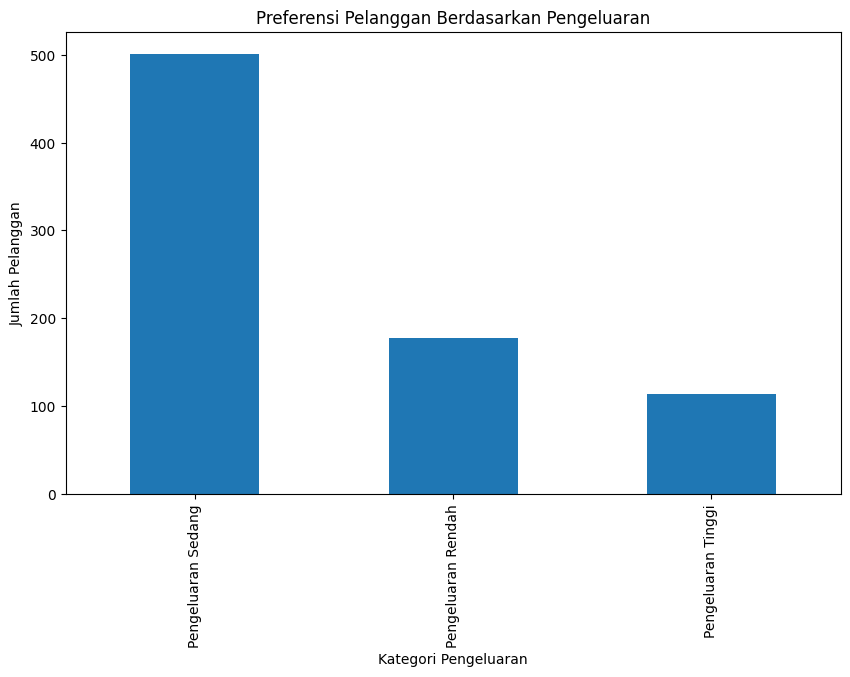

In [36]:
customer_spending = df.groupby('Customer ID')['Sales'].sum()
bins = [0, 1000, 5000, customer_spending.max()]
labels = ['Pengeluaran Rendah', 'Pengeluaran Sedang', 'Pengeluaran Tinggi']
customer_spending_categories = pd.cut(customer_spending, bins=bins, labels=labels)
customer_spending_categories.value_counts().plot(kind='bar', figsize=(10, 6), title='Preferensi Pelanggan Berdasarkan Pengeluaran')
plt.xlabel('Kategori Pengeluaran')
plt.ylabel('Jumlah Pelanggan')
plt.show()

##Analisis Tren Pasar

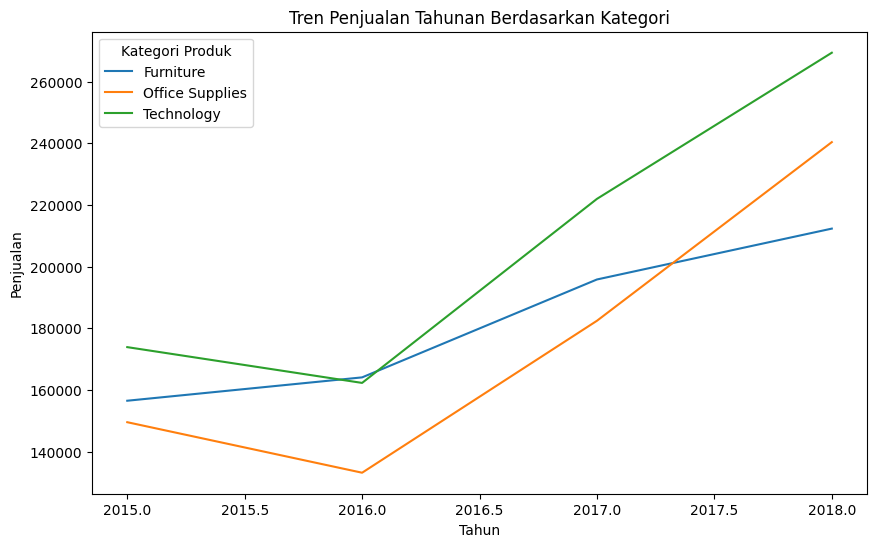

In [37]:
category_yearly_sales = df.groupby(['Year', 'Category'])['Sales'].sum().unstack()
category_yearly_sales.plot(kind='line', figsize=(10, 6), title='Tren Penjualan Tahunan Berdasarkan Kategori')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend(title='Kategori Produk')
plt.show()